# XGBClassifier

In [1]:
import some_load_train_evaluate_functions as ml

from xgboost import XGBClassifier

In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Diabetes data

diabetes_df = ml.get_data_of_disease(driver, 'Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


### Training

In [4]:
xg_boost = XGBClassifier()

# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

# Training

xg_boost.fit(X_train.values, y_train.values)

# Accuracy scores

y_pred = xg_boost.predict(X_val)

print('Training Accuracy: ',ml.accuracy_score(y_train, xg_boost.predict(X_train)))

print('Testing Accuracy: ',ml.accuracy_score(y_val, y_pred))

Training Accuracy:  0.9919876300253022
Testing Accuracy:  0.9921281979195952


## Feature Selection

### Correlation Analysis

In [5]:
xg_boost_test = XGBClassifier()

In [6]:
pos_corr, neg_corr = ml.get_correlated_features(diabetes_df,'Diabetes',pos=0.0,neg=-0.0)

corr_features = list(pos_corr.keys()[1:]) + list(neg_corr.keys())
corr_features.remove('Respondent_ID')
corr_features_ = list(pos_corr.keys()[1:15]) + list(neg_corr.keys()[:15])
corr_features_.remove('Respondent_ID')

corr_features_

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Triglyceride [mmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Triglyceride_HDL Ratio',
 'Segmented neutrophils [%]',
 'Neutrophil_Lymphocyte Ratio',
 'C-Reactive Protein [mg/L]',
 'Cobalt [nmol/L]',
 'Eosinophils [%]',
 'UIBC [umol/L]',
 'Nucleated RBCs',
 'Total Cholesterol [mmol/L]',
 'Cis-beta-carotene [umol/L]',
 'Creatine Phosphokinase [IU/L]',
 'Total Calcium [mg/dL]',
 'Trans-beta-carotene [umol/L]',
 'Alpha-carotene [umol/L]',
 'Total Protein [g/dL]',
 'RBC count [million cells/uL]',
 'Sodium [mmol/L]',
 'Alkaline Phosphatase [IU/L]']

In [7]:
ml.evaluate_feature_set(corr_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.989

Recall: 0.952

F1-Score: 0.971


### SelectFromModel

In [9]:
sfm_features = ml.select_from_model_features(ml.RandomForestClassifier(),X,y)
sfm_features

['Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Chromium [nmol/L]',
 'Cobalt [nmol/L]',
 'Fasting Glucose [mmol/L]',
 'Glycohemoglobin [%]',
 'Osmolality [mmol/Kg]',
 'Total Cholesterol [mmol/L]',
 'Insulin [pmol/L]']

In [10]:
sfm_features = list(sfm_features)

ml.evaluate_feature_set(sfm_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.985

Test Accuracy: 0.986

Precision: 0.998

Recall: 0.897

F1-Score: 0.945


### SelectKBest

In [11]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Lymphocyte [%]',
 'Insulin [pmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Segmented neutrophils [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-crypotoxanthin [umol/L]',
 'Albumin [g/dL]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Platelet_WBC Ratio',
 'C-Reactive Protein [mg/L]',
 'Creatinine [mg/dL]',
 'Ferritin [ng/mL]',
 'Chloride [mmol/L]',
 'Red cell distribution width [%]',
 'Triglyceride [mmol/L]',
 'A/G Ratio',
 'Platelet count [1000 cells/uL]',
 'Triglyceride_HDL Ratio',
 'Trans-lycopene [umol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Total Lycopene [umol/L]',
 'Mean platelet volume [fL]']

In [12]:
ml.evaluate_feature_set(k_best_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.991

Test Accuracy: 0.992

Precision: 0.991

Recall: 0.948

F1-Score: 0.969


### Recursive Feature Elimination (RFE) 

In [16]:
rfe_features = ml.select_rfe_features(ml.XGBClassifier(),X,y,n=30,step=0.5)
rfe_features[:30]

['Total Lycopene [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Alanine Aminotransferase [U/L]',
 'Albumin [g/dL]',
 'LDL_HDL Ratio',
 'Uric Acid [mg/dL]',
 'Hematocrit [%]',
 'Glycohemoglobin [%]',
 'Non_HDL Ratio',
 'Nucleated RBCs',
 'Fasting Glucose [mmol/L]',
 'Transferrin receptor [nmol/L]',
 'Trans-lycopene [umol/L]',
 'Trans-beta-carotene [umol/L]',
 'Lymphocyte_Monocyte Ratio',
 'Chromium [nmol/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Alpha-crypotoxanthin [umol/L]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Total Cholesterol [mmol/L]',
 'Insulin [pmol/L]',
 'Age',
 'Blood Urea Nitrogen [mg/dL]',
 'Beta-cryptoxanthin [umol/L]',
 'Basophils [%]',
 'Retinyl stearate [umol/L]',
 'BMI',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Transferrin Saturation [%]',
 'Lactate Dehydrogenase [IU/L]']

In [17]:
ml.evaluate_feature_set(rfe_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.991

Test Accuracy: 0.992

Precision: 1.000

Recall: 0.938

F1-Score: 0.968


### Lasso Regularization

In [18]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'Gender',
 'BMI',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Alkaline Phosphatase [IU/L]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Vitamin C [umol/L]',
 'Blood lead [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Aspartate Aminotransferase [U/L]',
 'Transferrin Saturation [%]',
 'Creatine Phosphokinase [IU/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Creatinine [mg/dL]',
 'White blood cell count [1000 cells/uL]',
 'Platelet_Lymphocyte Ratio',
 'Retinyl palmitate [umol/L]',
 'Total Cholestrol_HDL Ratio',
 'Uric Acid [mg/dL]',
 'Sodium [mmol/L]',
 'Bicarbonate [mmol/L]',
 'Direct HDL-Cholesterol [mmol/L]']

In [24]:
ml.evaluate_feature_set(l1_selected_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.996

Recall: 0.948

F1-Score: 0.971


### Relief F

In [21]:
relieff_features = ml.relief_feature_select(30,X,y)

In [22]:
relieff_features[:30]

['Age',
 'Glycohemoglobin [%]',
 'BMI',
 'Segmented neutrophils [%]',
 'Hematocrit [%]',
 'Lymphocyte [%]',
 'Hemoglobin [g/dL]',
 'Fasting Glucose [mmol/L]',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-tocopherol [umol/L]',
 'Osmolality [mmol/Kg]',
 'Mean cell volume [fL]',
 'Sodium [mmol/L]',
 'Total Cholestrol_HDL Ratio',
 'Total Iron Binding Capacity [umol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Chloride [mmol/L]',
 'Mean cell hemoglobin [pg]',
 'RBC count [million cells/uL]',
 'Total Protein [g/dL]',
 'Total Calcium [mg/dL]',
 'A/G Ratio',
 'Potassium [mmol/L]',
 'Uric Acid [mg/dL]',
 'Lactate Dehydrogenase [IU/L]',
 'Transferrin Saturation [%]',
 'Mean platelet volume [fL]']

In [25]:
ml.evaluate_feature_set(relieff_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.991

Recall: 0.948

F1-Score: 0.969


### XGBoost Feature Importances

In [5]:
def get_xgb_features(model, X_train):
    
    xgb_features = ml.pd.DataFrame(model.feature_importances_, index=X_train.columns,
                                             columns=['Importance'])
    xgb_features = xgb_features.sort_values('Importance', ascending=False)
    xgb_features = list(xgb_features.index)
    
    return xgb_features

In [6]:
xgb_features = get_xgb_features(xg_boost, X_train)
xgb_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Transferrin receptor [nmol/L]',
 'RBC count [million cells/uL]',
 'Iron [ug/dL]',
 'Non_HDL Ratio',
 'Blood Urea Nitrogen [mg/dL]',
 'LDL_HDL Ratio',
 'Lymphocyte_Monocyte Ratio',
 'Alanine Aminotransferase [U/L]',
 'Trans-lycopene [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Triglyceride_HDL Ratio',
 'C-Reactive Protein [mg/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Bicarbonate [mmol/L]',
 'UIBC [umol/L]',
 'Uric Acid [mg/dL]',
 'Triglyceride [mmol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Retinol [umol/L]',
 'Gamma-tocopherol [umol/L]',
 'Blood lead [umol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Red cell distribution width [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Chloride [mmol/L]',
 'A/G Ratio']

In [28]:
ml.evaluate_feature_set(xgb_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.989

Recall: 0.952

F1-Score: 0.971


### Optimal no. of features

In [7]:
final_features = list(xgb_features) 


Maximum accuracy = 0.9421 for 74 features


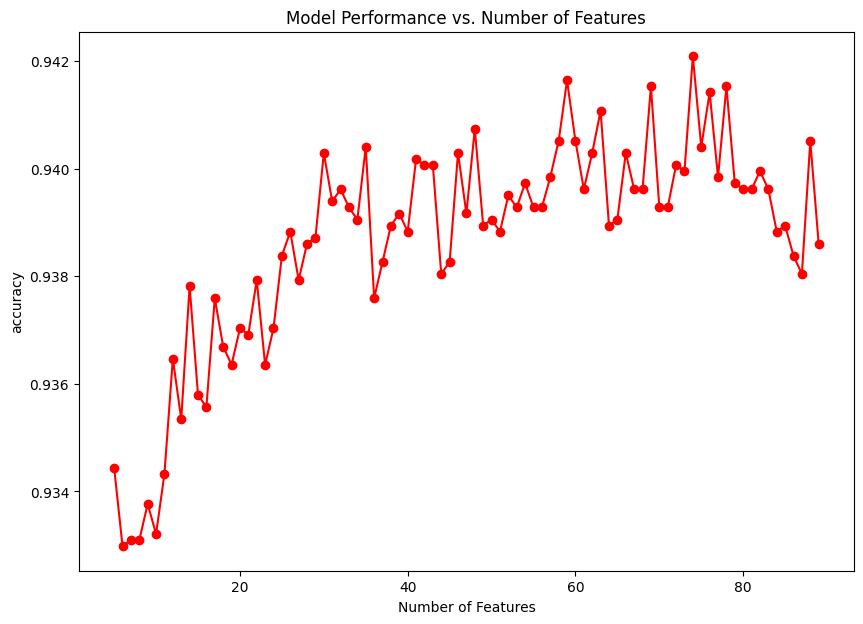

In [30]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='accuracy', val=True)


Maximum f1 = 0.7473 for 74 features


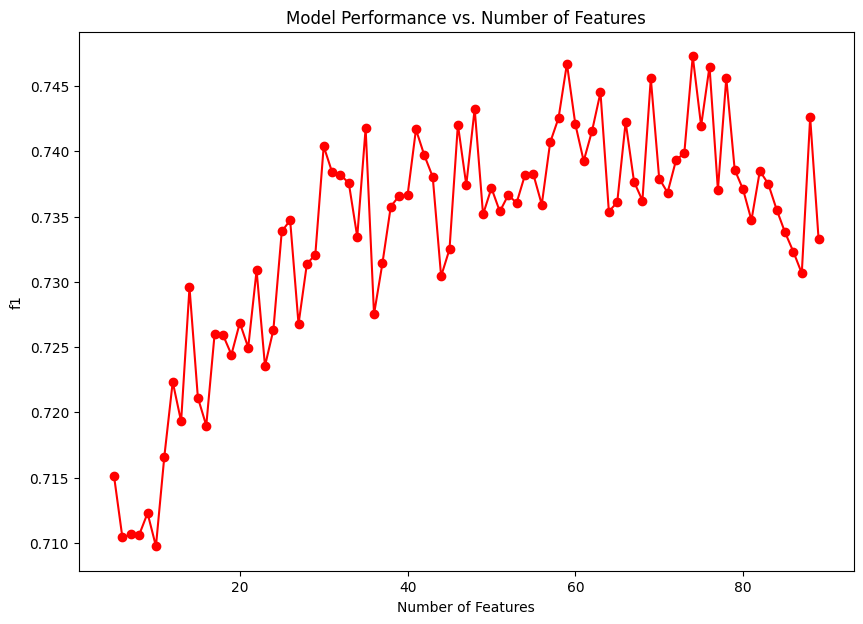

In [31]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='f1', val=True)


Maximum recall = 0.6567 for 76 features


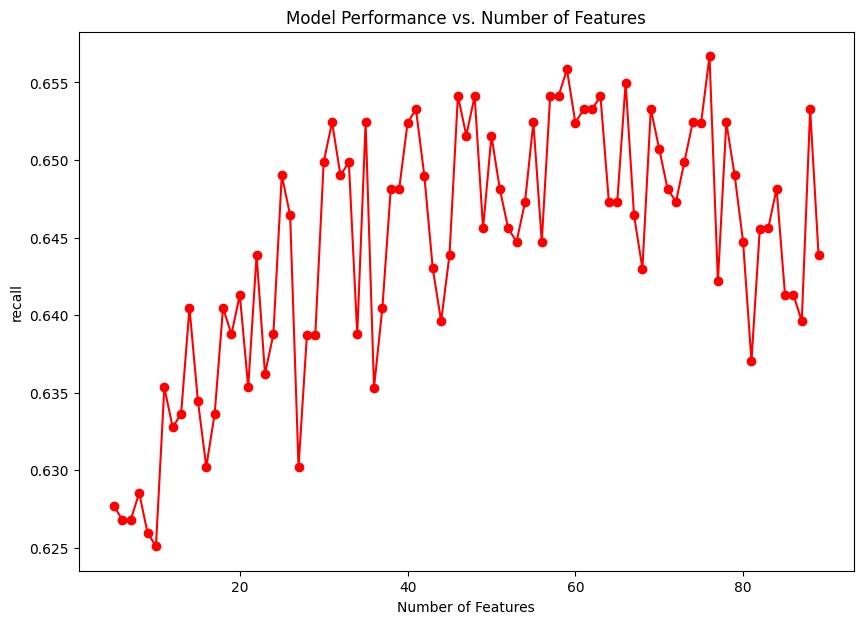

In [32]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='recall', val=True)


Maximum precision = 0.8779 for 74 features


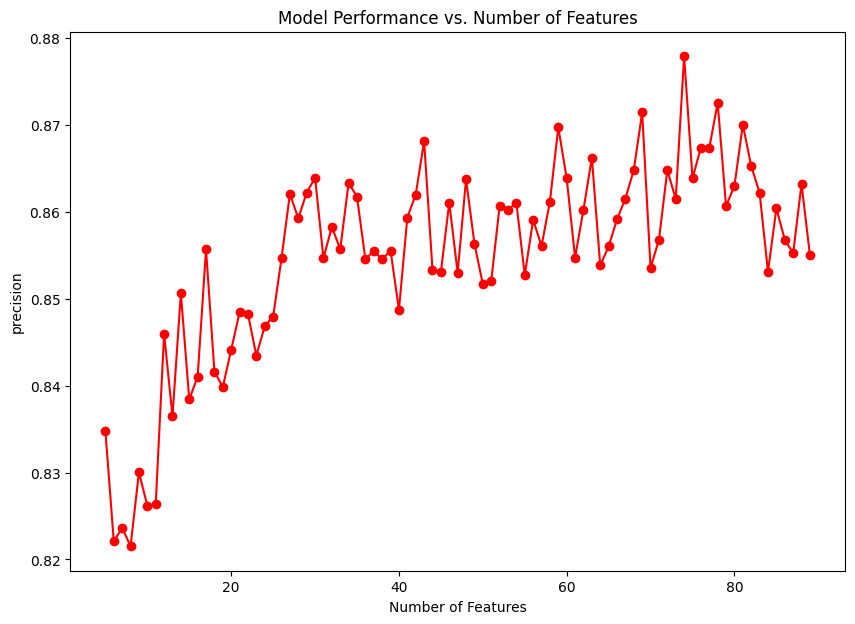

In [33]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='precision', val=True)

In [8]:
num_features = 74

selected = final_features[:num_features]
selected.append('Diabetes')

diabetes_df = diabetes_df[selected]

In [9]:
# Save feature set
    
with open('../Models/Diabetes/Feature Sets/XG Boost Features.pkl', 'wb') as f:
    ml.pickle.dump(selected, f)

## Preprocessing

### Zero Imputation

In [43]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                        impute = True, scale=True,
                                                        imputer=ml.SimpleImputer(strategy='constant',fill_value=0),
                                                        random_state=42)

In [45]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.993

Test Accuracy: 0.993

Precision: 0.991

Recall: 0.955

F1-Score: 0.973


### Mode Imputation

In [46]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [47]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.994

Recall: 0.950

F1-Score: 0.971


### Multiple Imputation by Chained Equations (MICE)

In [50]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.IterativeImputer(max_iter=20),
                                                              random_state=42)

In [51]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.992

Recall: 0.969

F1-Score: 0.980


### Median Imputation

In [52]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)

In [53]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.991

Recall: 0.950

F1-Score: 0.970


### Mean Imputation

In [54]:
# Splitting and Preprocessing data

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [55]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.991

Recall: 0.948

F1-Score: 0.969


### Dropping Null Values

In [56]:
# Drop null values
diabetes_df_na = diabetes_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df_na, label = 'Diabetes',
                                                              impute = False, scale=True,
                                                              random_state=42)

In [57]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)

# over-fitting


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### k-NN Imputation

In [58]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [59]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.994

Recall: 0.969

F1-Score: 0.981


## Oversampling and Undersampling

### Random Oversampling

In [61]:
X_ros, y_ros = ml.random_over_sample(X_train, y_train)

xg_boost.fit(X_ros.values, y_ros.values)

ml.evaluate_model_metrics(xg_boost,X_ros, y_ros,X_val, y_val)


Train Accuracy: 0.994

Test Accuracy: 0.989

Precision: 0.925

Recall: 0.998

F1-Score: 0.960


### SMOTE (Synthetic Minority Over-sampling Technique)

In [62]:
X_smote, y_smote = ml.smote_over_sample(X_train, y_train)

xg_boost.fit(X_smote.values, y_smote.values)

ml.evaluate_model_metrics(xg_boost,X_smote, y_smote,X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.990

Precision: 0.941

Recall: 0.992

F1-Score: 0.966


### Random Undersampling

In [63]:
X_rus, y_rus = ml.random_under_sample(X_train, y_train)

xg_boost.fit(X_rus.values, y_rus.values)

ml.evaluate_model_metrics(xg_boost,X_rus, y_rus,X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.906

Precision: 0.592

Recall: 0.994

F1-Score: 0.742


### Tomek Links

In [64]:
X_tomek, y_tomek = ml.tomek_links(X_train, y_train)

xg_boost.fit(X_tomek.values, y_tomek.values)

ml.evaluate_model_metrics(xg_boost,X_tomek, y_tomek,X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.994

Precision: 0.985

Recall: 0.967

F1-Score: 0.976


### SMOTE + Tomek Links

In [65]:
X_smote_tomek, y_smote_tomek = ml.smote_tomek(X_train, y_train)

xg_boost.fit(X_smote_tomek.values, y_smote_tomek.values)

ml.evaluate_model_metrics(xg_boost,X_smote_tomek, y_smote_tomek,X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.990

Precision: 0.941

Recall: 0.992

F1-Score: 0.966


In [66]:
# Model seems to perform better without oversampling or undersampling

## Hyperparameter Optimization 

In [68]:
param_grid = {
    
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.5, 2, 3],
    
}

### Random Search

In [73]:
rand_best_params, xg_boost_rand = ml.random_search_optimize(xg_boost,param_grid,n_iter=100,cv=5,
                                                               X_train=X_train, y_train=y_train,
                                                               scoring='accuracy', val=True)

In [74]:
rand_best_params

{'subsample': 1.0,
 'reg_lambda': 1.5,
 'reg_alpha': 0.2,
 'learning_rate': 0.2,
 'gamma': 0.2}

In [75]:
ml.evaluate_model_metrics(xg_boost_rand,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.973

F1-Score: 0.981


### Optuna

In [77]:
def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['subsample'] = trial.suggest_uniform('subsample', 0.1, 1.0)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)

    model = XGBClassifier(**params)
    
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)

    accuracy = ml.accuracy_score(y_test.values, y_pred)

    return accuracy

In [78]:
best_trial , xg_boost_opt = ml.optuna_optimize(objective, XGBClassifier, n_trials=150)

In [79]:
best_trial

{'booster': 'dart',
 'lambda': 2.310197100097172e-06,
 'alpha': 0.19329647452707094,
 'max_depth': 8,
 'eta': 0.7727415388203016,
 'gamma': 1.1424398845718018e-08,
 'grow_policy': 'lossguide',
 'subsample': 0.9798805881847164,
 'colsample_bytree': 0.10867663331855493}

In [80]:
xg_boost_opt.fit(X_train.values,y_train.values)

ml.evaluate_model_metrics(xg_boost_opt,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.992

Recall: 0.969

F1-Score: 0.980


## Evaluation on Test Set


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.991

Recall: 0.968

F1-Score: 0.980

Confusion Matrix:

[[3082    4]
 [  15  456]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      3086
     Class 1       0.99      0.97      0.98       471

    accuracy                           0.99      3557
   macro avg       0.99      0.98      0.99      3557
weighted avg       0.99      0.99      0.99      3557


ROC-AUC Curve:


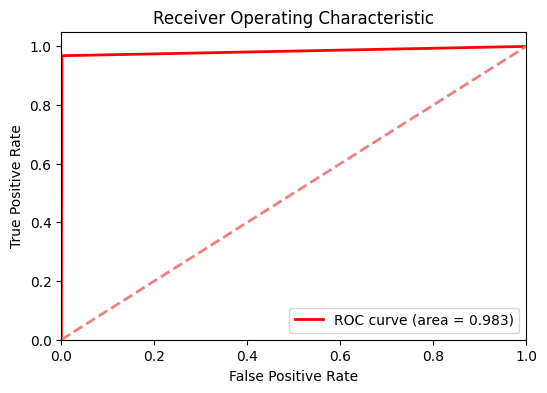

In [81]:
# After evaluating on the validation set, we evaluate and finalize on the test set

ml.evaluate_model_metrics(xg_boost_rand, X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

### K-fold

In [83]:
ml.k_cross_validate(xg_boost,X.values,y.values,cv=10,scoring='accuracy')


accuracy scores: [0.93258427 0.92921348 0.94606742 0.92575928 0.9223847  0.93700787
 0.94375703 0.93588301 0.91901012 0.93588301]

Mean accuracy score:  0.9327550207909405

Standard deviation:  0.008330049620121382


In [84]:
ml.k_cross_validate(xg_boost_rand,X.values,y,cv=10,scoring='accuracy')


accuracy scores: [0.93033708 0.92134831 0.94269663 0.928009   0.928009   0.93588301
 0.94375703 0.94263217 0.93138358 0.93700787]

Mean accuracy score:  0.9341063687263811

Standard deviation:  0.007140989275584797


In [85]:
ml.k_cross_validate(xg_boost_opt,X.values,y,cv=10,scoring='accuracy')


accuracy scores: [0.9        0.91573034 0.90898876 0.90663667 0.89313836 0.90438695
 0.90326209 0.91226097 0.90663667 0.91001125]

Mean accuracy score:  0.9061052059503798

Standard deviation:  0.00609197767535989


### Stratified K-fold

In [88]:
ml.stratified_k_cross_validate(xg_boost,X,y,n_splits=10)


Average Accuracy: 0.9353432085034316

Average Precision: 0.8359543362704333

Average Recall: 0.6335868462987106

Average F1-Score: 0.7195947114641557


In [89]:
ml.stratified_k_cross_validate(xg_boost_rand,X,y,n_splits=10)


Average Accuracy: 0.936355455568054

Average Precision: 0.8381672375120377

Average Recall: 0.641264667535854

Average F1-Score: 0.7254144803600306


In [90]:
ml.stratified_k_cross_validate(xg_boost_opt,X,y,n_splits=10)


Average Accuracy: 0.9035194196231089

Average Precision: 0.7113770178836945

Average Recall: 0.4542590178183398

Average F1-Score: 0.5530539133530187


### Save Model

In [91]:
final_xgb_estimator = xg_boost_rand

In [92]:
# Saving the model

ml.save_model(final_xgb_estimator, "../Models/Diabetes/XGBoost_Classifier.pkl")

Overwrite File? [y/n]: y
Saved Model


## Prediction

In [94]:
# Predicting on perturbed values

ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[0], y_test.iloc[0], 0.6)

Instance:
 [ 0.36734894  0.20113157  1.68064713  0.32501913 -0.02086379 -0.40152664
 -0.38450518  0.13249076  1.73847721  0.94336392 -0.622858   -0.3003398
  0.87643909 -0.21045816 -0.04890363  1.60281303  2.76148397  1.27049561
  0.01055338  0.44803325 -0.22521297  0.40787892  0.27812771 -1.39228388
  0.40169313 -0.83384209  1.29018049  0.596327   -1.33298943 -0.52864194
 -0.96900532  0.43624554 -0.46796923  0.53855018 -0.71169235  0.33744152
 -0.916044    0.90837587  0.05839468  1.46267272 -1.05249427  1.08546177
 -1.14405446  1.64312217 -0.06223616 -0.04128865 -0.25594488 -0.43382583
 -0.32332909  0.01563371 -0.4145887  -0.22035673  0.07423755 -0.08031934
  1.72744701 -0.35854866 -0.23689045  1.17609608  0.97770844 -0.81573801
  0.99131355  0.51235934 -0.04101856  0.29336512  0.63227289 -1.3195942
  0.09417937 -0.0414442  -0.54632302 -0.2499465  -1.02438466 -0.55399273
 -1.01691909  2.57105782]

Expected Class:  0

 Modified Instance:
 [ 0.36734894  0.37571473  1.53292904  0.4387332

In [101]:
ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[10], y_test.iloc[10], 1.5)

Instance:
 [ 1.60338376  0.10184065  1.72059969  1.13436215  0.33821578  0.22239382
 -0.41697107  1.7791151   3.09727519  0.95068506 -0.08676995  1.94474023
  3.74242015  1.31192239  0.41920732 -0.08737687  0.74803116  0.30285908
  0.18387095  0.83426975  0.57605187  0.37811641  1.8065121   0.42671065
  0.21215391 -0.47374685 -0.22536752 -0.4939886  -1.33298943 -0.26770554
 -1.35355226  0.92482815  0.88546295 -0.34567495 -0.55579524 -0.31480322
  0.60773024 -0.42614302  0.92092994  3.72749055 -0.88673191 -0.20413834
  0.19524739  0.6461751   0.84634419  3.19327016  1.06177088 -0.31914809
 -0.42345917  0.01563371 -0.01293943 -0.04936332 -0.2680369  -1.44064535
  1.72744701 -0.36093675 -0.28432441  0.35212829 -0.98399733  0.15961855
  0.31054954  2.29180163  0.41486173 -1.17643821 -1.79070164 -0.65899717
  1.00811838  0.93111981  0.698956    0.0902058   0.34906609  0.27705653
  1.97220693 -0.04081644]

Expected Class:  1

 Modified Instance:
 [ 1.60338376  0.18328172  1.53535005  1.30764